### Data sorting
Make a train, validation and test data folders

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil 

original_dataset_path = './data'

base_path = './melanoma_nevus'
if not os.path.isdir(base_path): os.mkdir(base_path)

# Make a new folders
train_folder = os.path.join(base_path, 'train')
if not os.path.isdir(train_folder): os.mkdir(train_folder)
validation_folder = os.path.join(base_path, 'validation')
if not os.path.isdir(validation_folder): os.mkdir(validation_folder)
test_folder = os.path.join(base_path, 'test')
if not os.path.isdir(test_folder): os.mkdir(test_folder)

train_melanoma_folder = os.path.join(train_folder, 'melanoma')
if not os.path.isdir(train_melanoma_folder): os.mkdir(train_melanoma_folder)
train_nevus_folder = os.path.join(train_folder, 'nevus')
if not os.path.isdir(train_nevus_folder): os.mkdir(train_nevus_folder)


validation_melanoma_folder = os.path.join(validation_folder, 'melanoma')
if not os.path.isdir(validation_melanoma_folder): os.mkdir(validation_melanoma_folder)
validation_nevus_folder = os.path.join(validation_folder, 'nevus')
if not os.path.isdir(validation_nevus_folder): os.mkdir(validation_nevus_folder)

test_melanoma_folder = os.path.join(test_folder, 'melanoma')
if not os.path.isdir(test_melanoma_folder): os.mkdir(test_melanoma_folder)
test_nevus_folder = os.path.join(test_folder, 'nevus')
if not os.path.isdir(test_nevus_folder): os.mkdir(test_nevus_folder)


In [3]:
# Get filenames for melanoma and nevus
melanoma_path = os.path.join(original_dataset_path, '1')
nevus_path = os.path.join(original_dataset_path, '0')

melanoma_filenames = [f for f in os.listdir(melanoma_path) if os.path.isfile(os.path.join(melanoma_path, f))]
nevus_filenames = [f for f in os.listdir(nevus_path) if os.path.isfile(os.path.join(nevus_path, f))]

In [4]:
from multiprocessing import Pool
from tqdm import tqdm

def save_processed_files(src_dst):
    img = image.load_img(src_dst[0])
    y = preprocess(np.array(img))
    image.save_img(src_dst[1],y)
    

# Copy images in to new folders
# split ratio (train, validation, test)
split_ratio = (0.7, 0.2, 0.1)

melanoma_src_dst = []
print("Melanoma files: {}".format(len(melanoma_filenames)))
for i in range(len(melanoma_filenames)):
    file_name = melanoma_filenames[i]
    
    src = os.path.join(melanoma_path, file_name)
    
    if i < split_ratio[0] * len(melanoma_filenames):
        # Train
        dst = os.path.join(train_melanoma_folder, file_name)
    elif i < split_ratio[0] * len(melanoma_filenames) + split_ratio[1] * len(melanoma_filenames):
        # Validation
        dst = os.path.join(validation_melanoma_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_melanoma_folder, file_name)
    
#     melanoma_src_dst+= [(src, dst)]
    shutil.copyfile(src, dst)

nevus_src_dst = []
print("Nevus files: {}".format(len(nevus_filenames)))
for i in range(len(nevus_filenames)):
    file_name = nevus_filenames[i]
    
    src = os.path.join(nevus_path, file_name)
    
    if i < split_ratio[0] * len(nevus_filenames):
        # Train
        dst = os.path.join(train_nevus_folder, file_name)
    elif i < split_ratio[0] * len(nevus_filenames) + split_ratio[1] * len(nevus_filenames):
        # Validation
        dst = os.path.join(validation_nevus_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_nevus_folder, file_name)
    
#     nevus_src_dst+= [(src, dst)]
    shutil.copyfile(src, dst)
    
# pool = Pool()
# pool.map(save_processed_files, melanoma_src_dst), total=len(melanoma_src_dst)
# pool.map(save_processed_files, nevus_src_dst), total=len(nevus_src_dst)
    
print('-'*32)
print('Melanoma train:', len(os.listdir(train_melanoma_folder)))
print('Melanoma validation:', len(os.listdir(validation_melanoma_folder)))
print('Melanoma test:', len(os.listdir(test_melanoma_folder)))
print('Nevus train:', len(os.listdir(train_nevus_folder)))
print('Nevus validation:', len(os.listdir(validation_nevus_folder)))
print('Nevus test:', len(os.listdir(test_nevus_folder)))


Melanoma files: 1000
Nevus files: 1000
--------------------------------
Melanoma train: 700
Melanoma validation: 200
Melanoma test: 100
Nevus train: 700
Nevus validation: 200
Nevus test: 100


### Make image generator

In [ ]:
from tensorflow.keras.preprocessing import image 
import matplotlib.pyplot as plt
import numpy as np
import cv2

def minmaxnorm(image):
    return (image - image.min())/(image.max() - image.min())

def centering(image):
    # Tryin to compute (-1)**(x+y)
    # make vectors
    M = image.shape[0]
    N = image.shape[1]

    x = np.matrix(np.arange(0,N,1))
    y = np.matrix(np.arange(0,M,1)).T

    # make matrixes
    x = np.repeat(x, M, axis=0)
    y = np.repeat(y, N, axis=1)

    x_y = np.add(x, y)

    # calculate powers of ones
    ones_power = np.power(-1, x_y)
    return np.multiply(image, ones_power)

def Butterworth(image, mode='lp', n=2, distance=-1):
    '''
    image - gray image, 2d np array
    mode - 'hp' for highpass, 'lp' for lowpass
    n - speed of slope decay 
    distance - radius of filter. -1 for auto (1/7 of min(sideLength))
    '''
    # 0. Normalization check
    if image.max() > 1:
        image = image / 255
        
    # 1. Centering of a image
    c_img = centering(image)

    # 2. Take FFT2 of centered image
    dft2 = np.fft.fft2(c_img)

    # 3. Construct a real, symmetric filter H(u,v) 
    #    distance = (u - P/2)^2 - (v - Q/2)^2
    #    here we use n and distance
    if distance == -1:
        D0 = np.min(c_img.shape)*(1/7)
    else:
        D0 = distance

    H = np.zeros(c_img.shape)
    for u in range(H.shape[0]):
        for v in range(H.shape[1]):
            dist = np.sqrt((u-H.shape[0]/2)**2 + (v-H.shape[1]/2)**2)
            H[u,v] = 1 / (1 + (D0/dist)**(2*n))
    if mode == 'lp':
        H -= 1

    # 4. Apply filter 
    G = np.multiply(H, dft2)
    idft2_G = np.fft.ifft2(G)
    # Normalizeing
    idft2_G /= np.max(idft2_G)
    idft2_G = centering(idft2_G).real
        
    return np.array(idft2_G)

In [ ]:
# Datagen preprocessing_function
def preprocess(img):
    # Correcting image format
    x = np.array(img, dtype='uint8')
    # Blur image
    x = cv2.GaussianBlur(x,(7,7),0)
    
    # Highpass Butterworth filter
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) #/255
    hp = Butterworth(gray, mode='hp', n=2, distance=12)
    hp = minmaxnorm(hp)
    hp_img = np.add(gray, hp)
    
    # Contrast Limited Adaptive Histogram Equalization
    norm_hp_img = minmaxnorm(hp_img)
    norm_hp_img = np.array(norm_hp_img*255, dtype='uint8')
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm_hp_img = clahe.apply(norm_hp_img)
    x = cv2.cvtColor(norm_hp_img, cv2.COLOR_GRAY2RGB)
    
    x = np.array(x, dtype='float32')
    return x

# img_path = fnames[12]
# img = image.load_img(img_path, target_size=(244, 244))
# x = np.array(img)
# y = preprocess(np.array(img))
# print("X:",x.shape,x.max(),x.min(),type(x),x.dtype)
# print("Y:",y.shape,y.max(),y.min(),type(y),y.dtype)

# plt.figure()
# plt.imshow(x/255, cmap='gray')
# plt.figure()
# plt.imshow(y/255, cmap='gray')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SIZE = (600,450)

# Rescale image values from 0..255 to 0..1
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=180,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    shear_range=0.1,
#                                    zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder, 
    target_size = (SIZE[0],SIZE[1]),
    batch_size = 20,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
    validation_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Network construction

In [10]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [1]:
'''
Define plot training function
'''
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [11]:
callbacks_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0.001, patience=5),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]

# My model
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(SIZE[0],SIZE[1],3)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(64,(4,4), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 596, 446, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 195, 145, 64)      32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 72, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 70, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 35, 128)       0         
_________________________________________

### Train model

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 70,
    epochs = 50,
    validation_data = valid_generator,
    validation_steps = 30,
    callbacks=callbacks_list)

# model.save('melanoma_nevus_1.h5')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1/50
70/70 [==============================] - 15s 209ms/step - loss: 0.7571 - acc: 0.4679 - val_loss: 0.6932 - val_acc: 0.4850
Epoch 2/50
70/70 [==============================] - 11s 161ms/step - loss: 0.6938 - acc: 0.4864 - val_loss: 0.6931 - val_acc: 0.4983
Epoch 3/50
70/70 [==============================] - 10s 150ms/step - loss: 0.6932 - acc: 0.4829 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 4/50
70/70 [==============================] - 10s 150ms/step - loss: 0.6932 - acc: 0.4929 - val_loss: 0.6931 - val_acc: 0.5067
Epoch 5/50
70/70 [==============================] - 11s 162ms/step - loss: 0.6933 - acc: 0.4800 - val_loss: 0.6931 - val_acc: 0.5083
Epoch 6/50
70/70 [=================

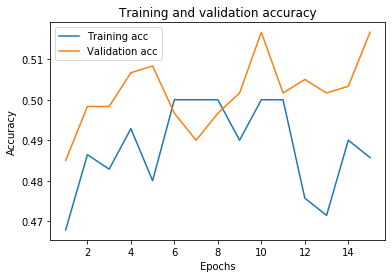

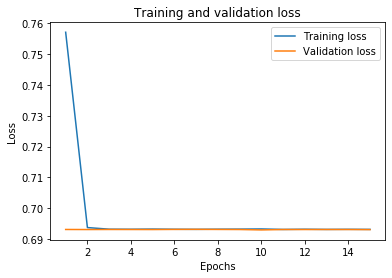

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Transfer learning

In [ ]:
import tensorflow
from tensorflow.keras.applications import ResNet50#InceptionResNetV2

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(SIZE[0], SIZE[1], 3))

conv_base.summary()

In [ ]:
from tensorflow.keras import regularizers
# Augment conv_base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Freeze conv_base 
conv_base.trainable = False

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [ ]:
callbacks_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0.001, patience=5),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]


history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = valid_generator,
    validation_steps = 50,
    callbacks=callbacks_list)

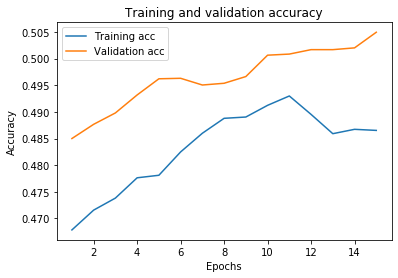

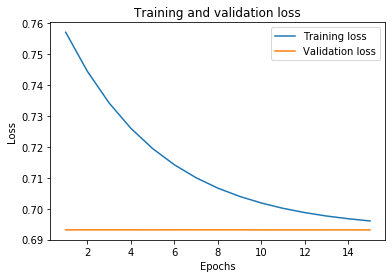

In [14]:
import matplotlib.pyplot as plt
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, smooth_curve(acc), label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Fine tuning 

In [ ]:
# 1. Add new layer 
# 2. Freeze base network
# 3. Train added layer
# 4. Unfreeze couple last layers of base network
# 5. Train this layers
import tensorflow
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
for layer in model.layers:
    if layer.name == 'resnet50':
        for l in layer.layers[165:]:
            layer.trainable = True
        for l in layer.layers[:165]:
            l.trainable = False

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

In [ ]:
callbacks_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0.001, patience=5),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=50,
    callbacks=callbacks_list)

### Test model

In [16]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
print("test acc:", test_acc)
print("test loss:", test_loss)


test acc: 0.5
test loss: 0.6931476759910583


### Visualization of intermediate activations

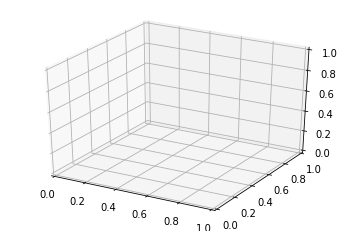

In [19]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')